Import libraries
<br>
Import library - library yang umum digunakan untuk modelling sebuah Convolutional Neural Network model

In [1]:
# Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.models import Sequential
import cv2 as cv
import os
from sklearn.model_selection import train_test_split

Menentukan header directory path dengan mengubah nilai variabel runtime_location untuk mempermudah load data 

In [ ]:
runtime_location = 'local' # 'local' or 'colab'
directory_header = 'drive/MyDrive/Hology/' if runtime_location == 'colab' else './'

if runtime_location == 'colab':
  from google.colab import drive
  drive.mount('/content/drive')

Load train csv data

In [3]:
# Load Train CSV

TRAIN_CSV_PATH = directory_header + 'dataset/train.csv'

df_train = pd.read_csv(TRAIN_CSV_PATH)

df_train.head()

,id,jenis,warna
0,1,1,1
1,2,0,2
2,3,1,3
3,4,1,1
4,5,0,4


Load train image data

In [4]:
# Load Train Images

X_raw_rgb = []
X_raw_gray = []
Y_shape = []
Y_color = []

TRAIN_IMG_PATH = directory_header + 'dataset/train/'

target_size = (224, 224)


for idx, file in enumerate(os.listdir(TRAIN_IMG_PATH)):

    file_path = os.path.join(TRAIN_IMG_PATH, file)

    # Load data in RGB format for color classification
    image_rgb = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image_rgb = tf.keras.preprocessing.image.img_to_array(image_rgb)
    # Load data in grayscale format for color classification
    image_gray = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=target_size)
    image_gray = tf.keras.preprocessing.image.img_to_array(image_gray)

    # Get file name
    file_id = os.path.splitext(file)[0]

    # Extract matching row, where id == name from train.csv
    matching_row = df_train[df_train['id'] == int(file_id)]

    if not matching_row.empty:
        X_raw_rgb.append(image_rgb)
        X_raw_gray.append(image_gray)
        Y_shape.append(matching_row['jenis'].values[0])
        Y_color.append(matching_row['warna'].values[0])
    else:
        print(f"No matching row found for file {file}")


# Convert to numpy array for easier manipulation
X_raw_gray = np.array(X_raw_gray)
X_raw_rgb = np.array(X_raw_rgb)
Y_shape = np.array(Y_shape)
Y_color = np.array(Y_color)

Preprocessing

In [5]:
# Check X, Y shape

print(f'X_rgb shape: {X_raw_rgb.shape}')
print(f'X_gray shape: {X_raw_gray.shape}')
print(f'Y_shape shape: {Y_shape.shape}')
print(f'Y_color shape: {Y_color.shape}\n')

# Check Y classes

shape_classes = np.unique(Y_shape)
color_classes = np.unique(Y_color)

print(f'Shape classes: {shape_classes}')
print(f'Color classes: {color_classes}')

X_rgb shape: (777, 224, 224, 3)
X_gray shape: (777, 224, 224, 1)
Y_shape shape: (777,)
Y_color shape: (777,)

Shape classes: [0 1]
Color classes: [0 1 2 3 4]


In [6]:
# Normalize X by pixel value

X_rgb_normalized = X_raw_rgb / 255
X_gray_normalized = X_raw_gray / 255

print(f'X rgb normalized minimum: {X_rgb_normalized.min()} | maximum: {X_rgb_normalized.max()}')
print(f'X gray normalized minimum: {X_gray_normalized.min()} | maximum: {X_gray_normalized.max()}')

X rgb normalized minimum: 0.0 | maximum: 1.0
X gray normalized minimum: 0.0 | maximum: 1.0


Label Classes

In [7]:
# Dictionary for label (based on kaggle's data)

index_to_shape_dict = {0 : 'Kaos', 1 : 'Hoodie'}
index_to_color_dict = {0: 'Merah', 1: 'Kuning', 2: 'Biru', 3: 'Hitam', 4: 'Putih'}

One-Hot Encoding

In [8]:
# Apply One hot encoding for Y_color (multi-class / more than 2)

def one_hot_encoding(Y: np.array, num_classes: int) -> np.array:

    encoded = tf.keras.utils.to_categorical(Y, num_classes= num_classes)

    return encoded

color_num_classes = color_classes.shape[0]

Y_color_encoded = one_hot_encoding(Y_color, color_num_classes)

print(Y_color_encoded.shape)

(777, 5)


Split data

In [9]:
# train test val split
# 80% train, 10% test, 10% val

X_rgb_normalized_hoodie = X_rgb_normalized[Y_shape == 1]
X_gray_normalized_hoodie = X_gray_normalized[Y_shape == 1]
Y_shape_hoodie = Y_shape[Y_shape == 1]
Y_color_encoded_hoodie = Y_color_encoded[Y_shape == 1]

X_rgb_normalized_kaos = X_rgb_normalized[Y_shape == 0][:len(X_rgb_normalized_hoodie)]
X_gray_normalized_kaos = X_gray_normalized[Y_shape == 0][:len(X_rgb_normalized_hoodie)]
Y_shape_kaos = Y_shape[Y_shape == 0][:len(X_rgb_normalized_hoodie)]
Y_color_encoded_kaos = Y_color_encoded[Y_shape == 0][:len(X_rgb_normalized_hoodie)]

# dataset split untuk yang rgb dulu (untuk model color classification)
X_rgb_kaos_train, X_rgb_kaos_temp, Y_color_encoded_kaos_train, Y_color_encoded_kaos_temp = train_test_split(X_rgb_normalized_kaos, Y_color_encoded_kaos, test_size=0.2, random_state=42)

X_rgb_kaos_test, X_rgb_kaos_val, Y_color_encoded_kaos_test, Y_color_encoded_kaos_val = train_test_split(X_rgb_kaos_temp, Y_color_encoded_kaos_temp, test_size=0.5, random_state=42)

X_rgb_hoodie_train, X_rgb_hoodie_temp, Y_color_encoded_hoodie_train, Y_color_encoded_hoodie_temp = train_test_split(X_rgb_normalized_hoodie, Y_color_encoded_hoodie, test_size=0.2, random_state=42)

X_rgb_hoodie_test, X_rgb_hoodie_val, Y_color_encoded_hoodie_test, Y_color_encoded_hoodie_val = train_test_split(X_rgb_hoodie_temp, Y_color_encoded_hoodie_temp, test_size=0.5, random_state=42)

X_rgb_train = np.concatenate([X_rgb_kaos_train, X_rgb_hoodie_train])
Y_color_encoded_train = np.concatenate([Y_color_encoded_kaos_train, Y_color_encoded_hoodie_train])

X_rgb_val = np.concatenate([X_rgb_kaos_val, X_rgb_hoodie_val])
Y_color_encoded_val = np.concatenate([Y_color_encoded_kaos_val, Y_color_encoded_hoodie_val])

X_rgb_test = np.concatenate([X_rgb_kaos_test, X_rgb_hoodie_test])
Y_color_encoded_test = np.concatenate([Y_color_encoded_kaos_test, Y_color_encoded_hoodie_test])


# dataset split untuk yang grayscale (untuk model shape classification)
X_gray_kaos_train, X_gray_kaos_temp, Y_shape_kaos_train, Y_shape_kaos_temp = train_test_split(X_gray_normalized_kaos, Y_shape_kaos, test_size=0.35, random_state=42)

X_gray_kaos_test, X_gray_kaos_val, Y_shape_kaos_test, Y_shape_kaos_val = train_test_split(X_gray_kaos_temp, Y_shape_kaos_temp, test_size=0.5, random_state=42)

X_gray_hoodie_train, X_gray_hoodie_temp, Y_shape_hoodie_train, Y_shape_hoodie_temp = train_test_split(X_gray_normalized_hoodie, Y_shape_hoodie, test_size=0.35, random_state=42)

X_gray_hoodie_test, X_gray_hoodie_val, Y_shape_hoodie_test, Y_shape_hoodie_val = train_test_split(X_gray_hoodie_temp, Y_shape_hoodie_temp, test_size=0.5, random_state=42)

X_gray_train = np.concatenate([X_gray_kaos_train, X_gray_hoodie_train])
Y_shape_train = np.concatenate([Y_shape_kaos_train, Y_shape_hoodie_train])

X_gray_val = np.concatenate([X_gray_kaos_val, X_gray_hoodie_val])
Y_shape_val = np.concatenate([Y_shape_kaos_val, Y_shape_hoodie_val])

X_gray_test = np.concatenate([X_gray_kaos_test, X_gray_hoodie_test])
Y_shape_test = np.concatenate([Y_shape_kaos_test, Y_shape_hoodie_test])

# Check shape

print(f"X_rgb_train shape: {X_rgb_train.shape} | test: {X_rgb_test.shape} | val: {X_rgb_val.shape}")
print(f"Y_color_encoded_train shape: {Y_color_encoded_train.shape} | test: {Y_color_encoded_test.shape} | val: {Y_color_encoded_val.shape}")

print(f"X_gray_train shape: {X_gray_train.shape} | test: {X_gray_test.shape} | val: {X_gray_val.shape}")
print(f"Y_shape_train shape: {Y_shape_train.shape} | test: {Y_shape_test.shape} | val: {Y_shape_val.shape}")

X_rgb_train shape: (480, 224, 224, 3) | test: (60, 224, 224, 3) | val: (62, 224, 224, 3)
Y_color_encoded_train shape: (480, 5) | test: (60, 5) | val: (62, 5)
X_gray_train shape: (390, 224, 224, 1) | test: (106, 224, 224, 1) | val: (106, 224, 224, 1)
Y_shape_train shape: (390,) | test: (106,) | val: (106,)


Shuffle dataset

In [10]:
from sklearn.utils import shuffle

# Shuffle the training set
X_rgb_train, Y_color_encoded_train = shuffle(X_rgb_train, Y_color_encoded_train, random_state=0)
X_rgb_val, Y_color_encoded_val = shuffle(X_rgb_val, Y_color_encoded_val, random_state=0)
X_rgb_test, Y_color_encoded_test = shuffle(X_rgb_test, Y_color_encoded_test, random_state=0)

X_gray_train, Y_shape_train = shuffle(X_gray_train, Y_shape_train, random_state=0)
X_gray_val, Y_shape_val = shuffle(X_gray_val, Y_shape_val, random_state=0)
X_gray_test, Y_shape_test = shuffle(X_gray_test, Y_shape_test, random_state=0)

<h1>Shape classifier modelling</h1>

In [11]:
SHAPE_CLASSIFIER_INPUT_SHAPE = X_gray_train[0].shape
print(SHAPE_CLASSIFIER_INPUT_SHAPE)

(224, 224, 1)


In [12]:

import cv2 as cv
import numpy as np

def apply_sobel_filter(X_gray):
    """
    Applies the Sobel operator to a list of grayscale images.

    Args:
    X_gray (list or np.array): List or array of grayscale images.

    Returns:
    np.array: Array of images after applying Sobel operator.
    """
    sobel_results = []

    for img in X_gray:
        # Apply Sobel operator in the x direction
        sobel_x = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=7)
        # Apply Sobel operator in the y direction
        sobel_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=7)

        # Calculate the gradient magnitude
        sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

        # Normalize to uint8 (0-255)
        sobel_magnitude = np.uint8(np.clip(sobel_magnitude, 0, 255))

        # Append the combined results to the list
        sobel_results.append(sobel_magnitude)

    # Convert the list to a NumPy array
    return np.expand_dims(np.array(sobel_results), axis=-1)

# Example usage
X_gray_sobel_train = apply_sobel_filter(X_gray_train)
X_gray_sobel_val = apply_sobel_filter(X_gray_val)


Plot sample data

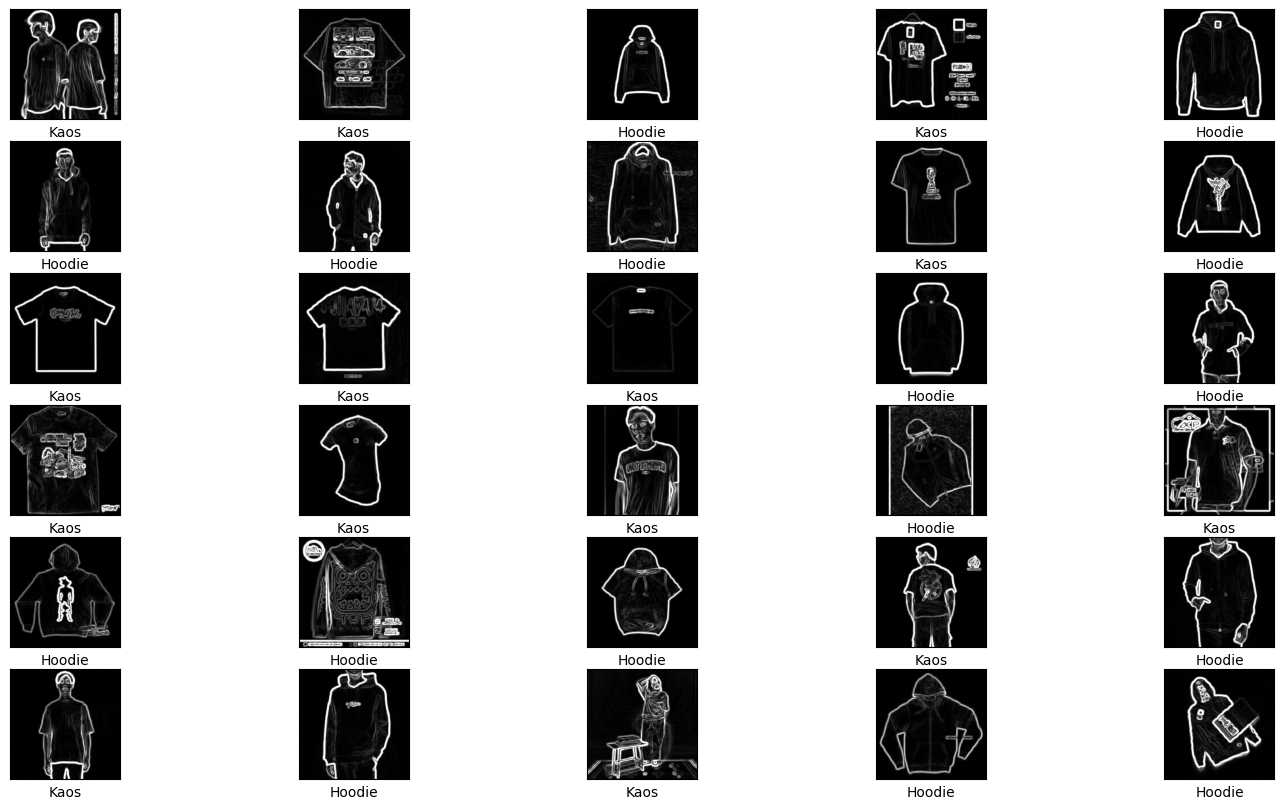

In [13]:
plt.figure(figsize=(18, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_gray_sobel_train[i], cmap='gray')
    plt.xlabel(index_to_shape_dict[Y_shape_train[i]])
plt.show()

In [14]:
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=SHAPE_CLASSIFIER_INPUT_SHAPE),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Dropout(0.1),

#     Flatten(),

#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

# (Strided CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=SHAPE_CLASSIFIER_INPUT_SHAPE),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

lr = 0.00001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

def build_light_vgg(input_shape):
    model = Sequential([
        # First block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2), input_shape=input_shape),
        Conv2D(32, (5, 5), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2), input_shape=input_shape),
        Conv2D(32, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(64, (5, 5), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(64, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(128, (5, 5), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(128, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Fourth block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(256, (5, 5), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(256, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Fifth block
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(512, (5, 5), activation='relu'),
        tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
        Conv2D(512, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Global Average Pooling
        tf.keras.layers.GlobalAveragePooling2D(),

        # Dense layers
        Dense(4096, activation='relu'),
        Dropout(0.5),

        Dense(1000, activation='relu'),
        Dropout(0.5),

        Dense(1, activation='sigmoid')  # Final classification
    ])

    return model


# Learning rate
lr = 0.00003

# Create the model
model = build_light_vgg(SHAPE_CLASSIFIER_INPUT_SHAPE)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 228, 228, 1)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      832       
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 228, 228, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      25632     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                      

Train model

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define an image data generator with augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Fit the generator to your training data
data_gen.fit(X_gray_sobel_train)
train_generator = data_gen.flow(X_gray_sobel_train, Y_shape_train, batch_size=16)


In [17]:
epochs = 50

history = model.fit(train_generator,
                    validation_data=(X_gray_sobel_val, Y_shape_val),
                    epochs=epochs, batch_size= 16)

Epoch 1/50
25/25 [==============================] - 32s 529ms/step - loss: 0.7462 - accuracy: 0.5333 - val_loss: 0.6916 - val_accuracy: 0.4811
Epoch 2/50
25/25 [==============================] - 6s 250ms/step - loss: 0.7014 - accuracy: 0.5359 - val_loss: 0.6871 - val_accuracy: 0.5283
Epoch 3/50
25/25 [==============================] - 6s 256ms/step - loss: 0.6428 - accuracy: 0.6359 - val_loss: 0.6836 - val_accuracy: 0.6415
Epoch 4/50
25/25 [==============================] - 7s 258ms/step - loss: 0.6138 - accuracy: 0.6385 - val_loss: 0.6808 - val_accuracy: 0.6038
Epoch 5/50
25/25 [==============================] - 6s 252ms/step - loss: 0.5899 - accuracy: 0.6692 - val_loss: 0.6909 - val_accuracy: 0.5094
Epoch 6/50
25/25 [==============================] - 6s 253ms/step - loss: 0.5527 - accuracy: 0.7205 - val_loss: 0.6503 - val_accuracy: 0.6792
Epoch 7/50
25/25 [==============================] - 6s 257ms/step - loss: 0.5174 - accuracy: 0.7205 - val_loss: 0.6651 - val_accuracy: 0.6604
Epoch

Analyze model result

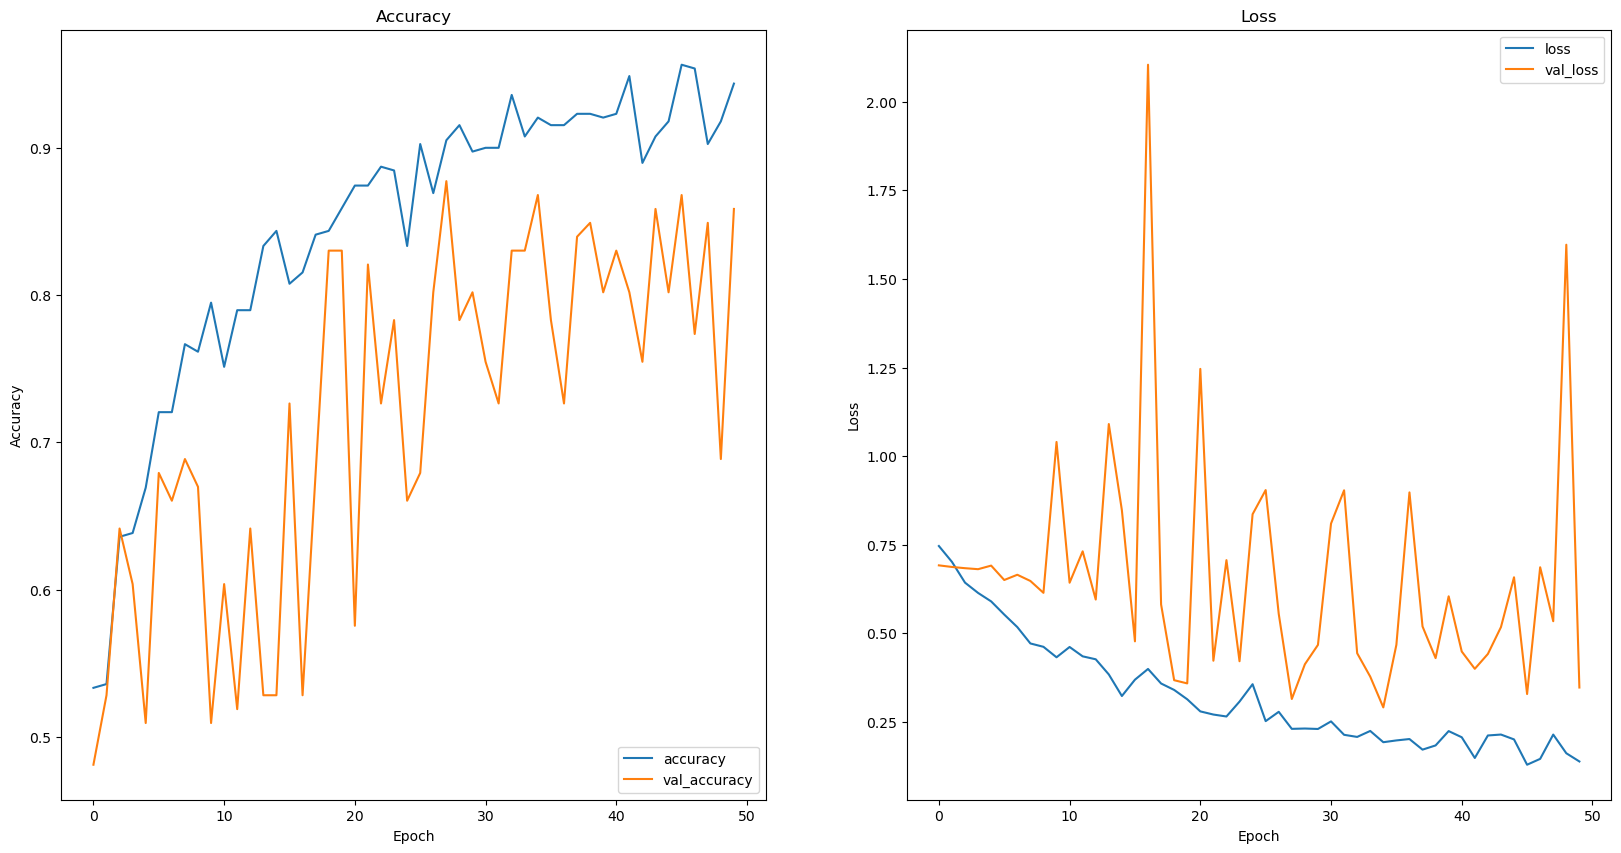

In [18]:
# Plot accuracy and loss

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Loss")

plt.show()

In [19]:
# Print test accuracy
test_loss, test_accuracy = model.evaluate(apply_sobel_filter(X_gray_test), Y_shape_test)

print(f"Test accuracy: {test_accuracy}")

4/4 [==============================] - 4s 71ms/step - loss: 0.3896 - accuracy: 0.8491
Test accuracy: 0.849056601524353


<h1>Color Classifier Modelling</h1>

In [20]:
COLOR_CLASSIFIER_INPUT_SHAPE = X_rgb_train[0].shape
print(COLOR_CLASSIFIER_INPUT_SHAPE)

(224, 224, 3)


Plot sample data

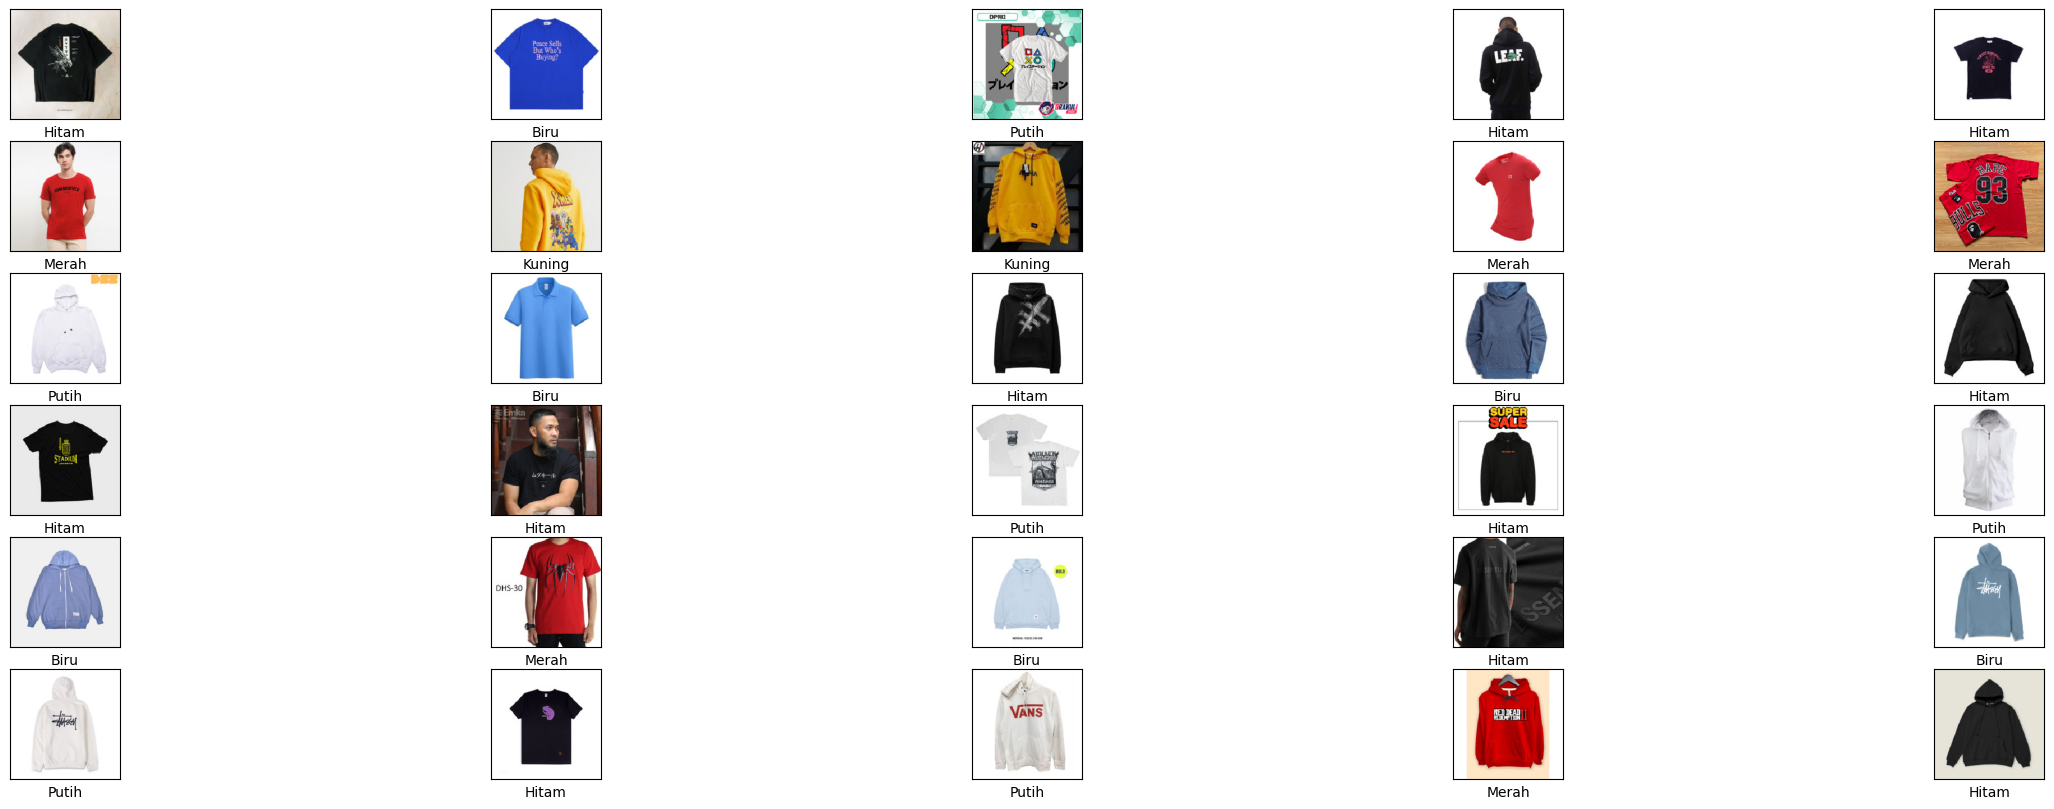

In [21]:
plt.figure(figsize=(30, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_rgb_train[i])
    plt.xlabel(index_to_color_dict[np.argmax(Y_color_encoded_train[i])])
plt.show()

In [22]:
# (Strided CNN)
color_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=COLOR_CLASSIFIER_INPUT_SHAPE),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(color_num_classes, activation='softmax')
])

print(color_model.summary())

lr = 0.0003
epochs = 30

color_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

color_history = color_model.fit(X_rgb_train, Y_color_encoded_train,
                    validation_data=(X_rgb_val, Y_color_encoded_val),
                    epochs=epochs,
                    )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 64)                6422592   
                                                                 
 dense_6 (Dense)             (None, 5)                

In [23]:
color_test_loss, color_test_acc = color_model.evaluate(X_rgb_test, Y_color_encoded_test)

print(f"Test accuracy: {color_test_acc}")

2/2 [==============================] - 0s 136ms/step - loss: 0.1740 - accuracy: 0.9333
Test accuracy: 0.9333333373069763


Load submission data

In [24]:
X_shape_to_be_predicted = []
X_color_to_be_predicted = []
filenames = []

TEST_IMG_PATH = directory_header + "dataset/test/"
target_size = (224, 224)

for file in os.listdir(TEST_IMG_PATH):
    file_path = os.path.join(TEST_IMG_PATH, file)

    # Load data in grayscale format for uniformity
    image_gray = tf.keras.preprocessing.image.load_img(
        file_path, color_mode="grayscale", target_size=target_size
    )
    image_gray = tf.keras.preprocessing.image.img_to_array(image_gray)

    image_rgb = tf.keras.preprocessing.image.load_img(
        file_path, color_mode="rgb", target_size=target_size
    )
    image_rgb = tf.keras.preprocessing.image.img_to_array(image_rgb)

    X_shape_to_be_predicted.append(image_gray)
    X_color_to_be_predicted.append(image_rgb)
    filenames.append(file)  # Track the filename

# Convert images to numpy array for easier manipulation
X_shape_to_be_predicted = np.array(X_shape_to_be_predicted)
X_color_to_be_predicted = np.array(X_color_to_be_predicted)

# Normalize the images
X_shape_to_be_predicted_normalized = X_shape_to_be_predicted / 255.0
X_color_to_be_predicted_normalized = X_color_to_be_predicted / 255.0

In [25]:
# Make predictions
X_shape_to_be_predicted_sobel = apply_sobel_filter(X_shape_to_be_predicted_normalized)
shape_prediction_result = model.predict(X_shape_to_be_predicted_sobel)

# Convert predictions to binary classes
shape_prediction_result_class = [0 if prediction < 0.5 else 1 for prediction in shape_prediction_result]

# Print results with filenames
shape_predictions_with_filenames = list(zip(filenames, shape_prediction_result_class))
for filename, prediction in shape_predictions_with_filenames:
    print(f"Image: {filename}, Shape: {prediction}")

11/11 [==============================] - 3s 268ms/step
Image: 1000.jpg, Shape: 0
Image: 1001.jpg, Shape: 1
Image: 1002.jpg, Shape: 0
Image: 1003.png, Shape: 0
Image: 1004.jpg, Shape: 1
Image: 1005.jpg, Shape: 0
Image: 1006.png, Shape: 1
Image: 1007.jpg, Shape: 0
Image: 1008.png, Shape: 0
Image: 1009.jpg, Shape: 0
Image: 1010.jpg, Shape: 0
Image: 1011.jpg, Shape: 0
Image: 1012.jpg, Shape: 0
Image: 1013.jpg, Shape: 0
Image: 1014.jpg, Shape: 0
Image: 1015.jpg, Shape: 1
Image: 1016.jpg, Shape: 0
Image: 1017.jpg, Shape: 1
Image: 1018.jpg, Shape: 0
Image: 1019.jpg, Shape: 0
Image: 1020.jpg, Shape: 1
Image: 1021.jpg, Shape: 1
Image: 1022.png, Shape: 1
Image: 1023.jpg, Shape: 1
Image: 1024.jpg, Shape: 0
Image: 1025.jpg, Shape: 0
Image: 1026.png, Shape: 0
Image: 1027.jpg, Shape: 0
Image: 1028.jpg, Shape: 0
Image: 1029.jpg, Shape: 1
Image: 1030.png, Shape: 1
Image: 1031.png, Shape: 0
Image: 1032.jpg, Shape: 0
Image: 1033.jpg, Shape: 1
Image: 1034.jpg, Shape: 1
Image: 1035.jpg, Shape: 0
Image: 10

Show predictions

In [26]:
color_prediction_result = color_model.predict(X_color_to_be_predicted_normalized)
print("Raw predictions (probabilities):", color_prediction_result)

# Find the class with the highest probability for each prediction
color_prediction_result_class = np.argmax(color_prediction_result, axis=1)

print("Predicted classes:", color_prediction_result_class)

11/11 [==============================] - 0s 22ms/step
Raw predictions (probabilities): [[1.3920239e-09 1.9248258e-05 4.3127646e-05 7.5896764e-08 9.9993753e-01]
 [9.8952441e-08 9.9998796e-01 1.5807886e-14 3.2194596e-06 8.6477503e-06]
 [2.1832764e-05 7.4798398e-04 6.3475040e-03 2.0882460e-01 7.8405809e-01]
 ...
 [6.3314733e-06 2.6339987e-05 1.6898199e-05 9.9993587e-01 1.4541218e-05]
 [8.8240198e-10 1.0000000e+00 5.1926534e-20 6.3703793e-09 1.0021688e-08]
 [1.4044432e-08 3.6911484e-07 3.0754542e-08 9.9999964e-01 1.2767008e-08]]
Predicted classes: [4 1 4 4 3 3 4 0 2 3 3 3 2 0 4 3 2 2 2 2 0 3 1 4 4 4 1 2 2 3 1 2 4 0 0 4 2
 3 3 1 2 2 2 0 2 4 1 3 1 0 3 4 2 0 3 3 2 3 2 1 2 2 0 1 4 2 3 3 3 3 1 4 1 4
 3 4 3 3 4 1 0 3 2 0 3 0 3 4 3 2 3 3 2 0 1 4 4 3 1 3 4 3 4 4 0 0 3 0 4 2 3
 0 3 3 2 1 3 3 1 3 2 3 3 4 2 2 3 0 4 0 1 2 1 4 2 3 0 1 3 3 2 3 2 4 1 0 2 2
 0 3 3 2 3 3 1 2 3 1 4 2 0 0 4 4 1 4 4 2 4 0 4 2 3 3 3 0 0 4 3 4 3 1 4 0 4
 2 4 3 2 0 1 3 1 0 0 3 3 2 3 1 0 4 2 2 4 2 4 3 4 4 4 1 3 2 3 3 2 3 3 3 4 2


In [27]:
color_predictions_with_filenames = list(zip(filenames, color_prediction_result_class))
for filename, prediction in color_predictions_with_filenames:
    print(f"Image: {filename}, Shape: {prediction}")

Image: 1000.jpg, Shape: 4
Image: 1001.jpg, Shape: 1
Image: 1002.jpg, Shape: 4
Image: 1003.png, Shape: 4
Image: 1004.jpg, Shape: 3
Image: 1005.jpg, Shape: 3
Image: 1006.png, Shape: 4
Image: 1007.jpg, Shape: 0
Image: 1008.png, Shape: 2
Image: 1009.jpg, Shape: 3
Image: 1010.jpg, Shape: 3
Image: 1011.jpg, Shape: 3
Image: 1012.jpg, Shape: 2
Image: 1013.jpg, Shape: 0
Image: 1014.jpg, Shape: 4
Image: 1015.jpg, Shape: 3
Image: 1016.jpg, Shape: 2
Image: 1017.jpg, Shape: 2
Image: 1018.jpg, Shape: 2
Image: 1019.jpg, Shape: 2
Image: 1020.jpg, Shape: 0
Image: 1021.jpg, Shape: 3
Image: 1022.png, Shape: 1
Image: 1023.jpg, Shape: 4
Image: 1024.jpg, Shape: 4
Image: 1025.jpg, Shape: 4
Image: 1026.png, Shape: 1
Image: 1027.jpg, Shape: 2
Image: 1028.jpg, Shape: 2
Image: 1029.jpg, Shape: 3
Image: 1030.png, Shape: 1
Image: 1031.png, Shape: 2
Image: 1032.jpg, Shape: 4
Image: 1033.jpg, Shape: 0
Image: 1034.jpg, Shape: 0
Image: 1035.jpg, Shape: 4
Image: 1036.png, Shape: 2
Image: 1037.jpg, Shape: 3
Image: 1038.

Finalize predictions for submission

In [28]:
predictions_for_submission = []

for (filename, color_prediction), (filename, shape_prediction) in zip(color_predictions_with_filenames, shape_predictions_with_filenames):
    predictions_for_submission.append((filename, shape_prediction, color_prediction))

In [29]:
print(predictions_for_submission)

[('1000.jpg', 0, 4), ('1001.jpg', 1, 1), ('1002.jpg', 0, 4), ('1003.png', 0, 4), ('1004.jpg', 1, 3), ('1005.jpg', 0, 3), ('1006.png', 1, 4), ('1007.jpg', 0, 0), ('1008.png', 0, 2), ('1009.jpg', 0, 3), ('1010.jpg', 0, 3), ('1011.jpg', 0, 3), ('1012.jpg', 0, 2), ('1013.jpg', 0, 0), ('1014.jpg', 0, 4), ('1015.jpg', 1, 3), ('1016.jpg', 0, 2), ('1017.jpg', 1, 2), ('1018.jpg', 0, 2), ('1019.jpg', 0, 2), ('1020.jpg', 1, 0), ('1021.jpg', 1, 3), ('1022.png', 1, 1), ('1023.jpg', 1, 4), ('1024.jpg', 0, 4), ('1025.jpg', 0, 4), ('1026.png', 0, 1), ('1027.jpg', 0, 2), ('1028.jpg', 0, 2), ('1029.jpg', 1, 3), ('1030.png', 1, 1), ('1031.png', 0, 2), ('1032.jpg', 0, 4), ('1033.jpg', 1, 0), ('1034.jpg', 1, 0), ('1035.jpg', 0, 4), ('1036.png', 0, 2), ('1037.jpg', 1, 3), ('1038.jpg', 0, 3), ('1039.jpg', 0, 1), ('1040.jpg', 0, 2), ('1041.png', 0, 2), ('1042.png', 0, 2), ('1043.jpg', 1, 0), ('1044.jpg', 0, 2), ('1045.jpg', 1, 4), ('1046.jpg', 0, 1), ('1047.jpg', 0, 3), ('1048.jpg', 1, 1), ('1049.jpg', 0, 0),

Plot predictions

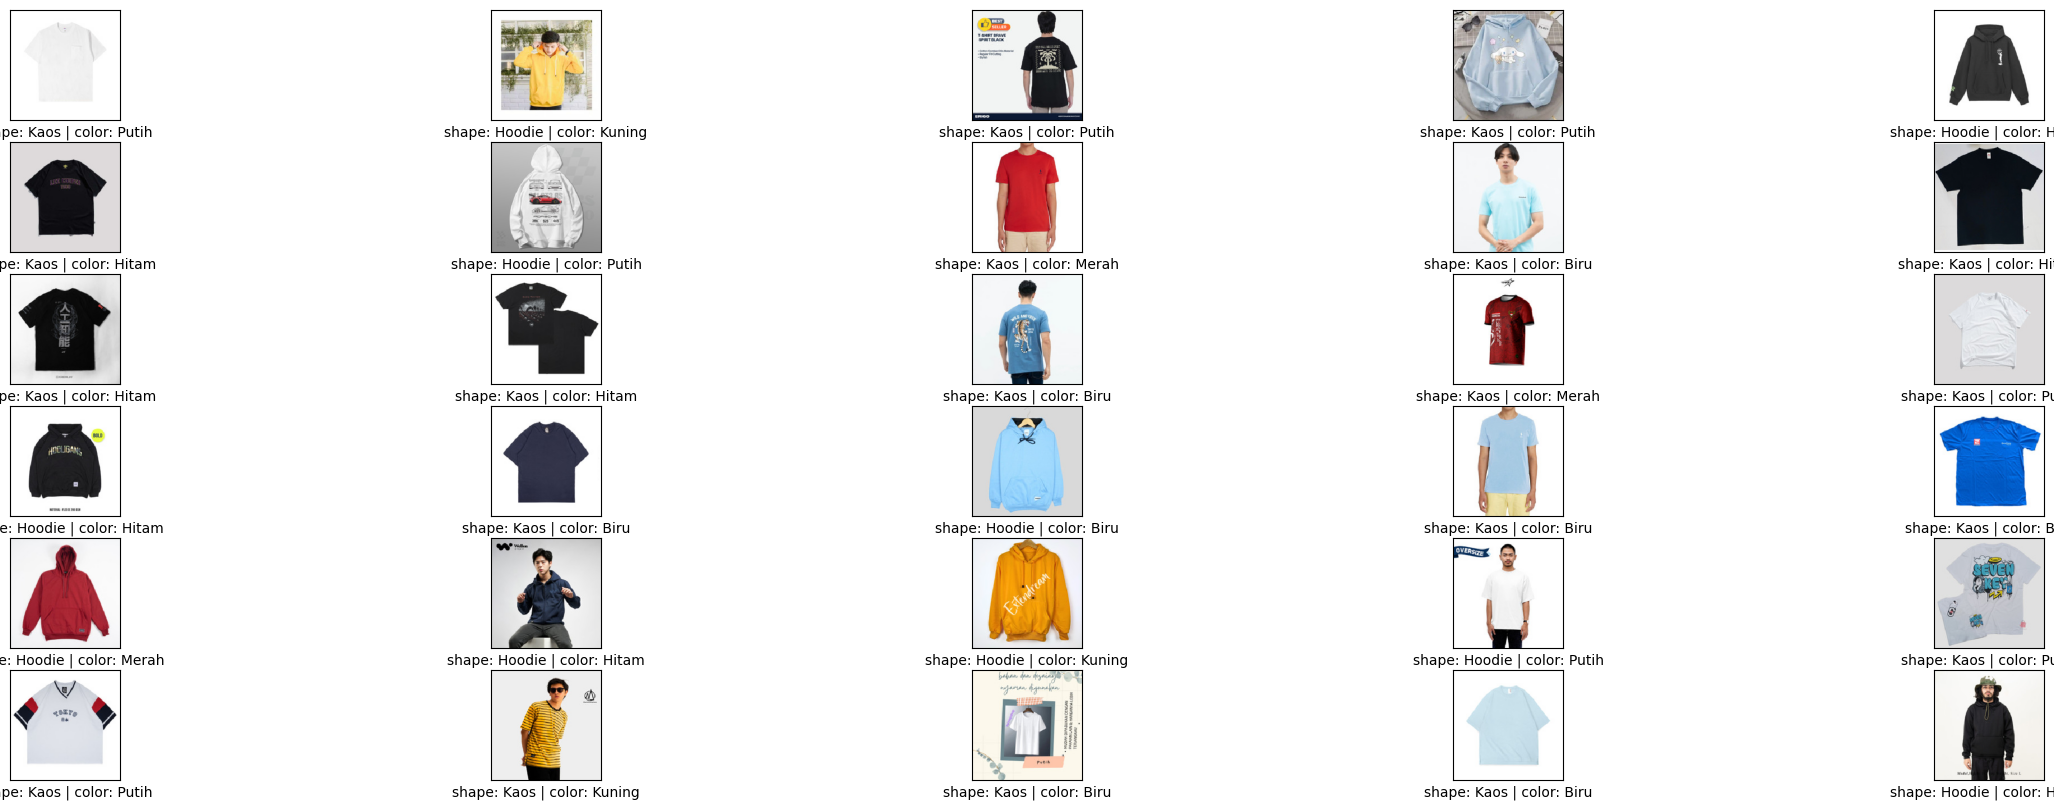

In [30]:
plt.figure(figsize=(30, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_color_to_be_predicted_normalized[i])
    plt.xlabel(f'shape: {index_to_shape_dict[predictions_for_submission[i][1]]} | color: {index_to_color_dict[predictions_for_submission[i][2]]}')
plt.show()

In [31]:
import pandas as pd

# Initialize an empty list to store DataFrames
dataframes = []

# Assuming predictions_for_submission is already defined
for (filename, shape_prediction, color_prediction) in predictions_for_submission:
    # Create a DataFrame for each prediction
    temp_df = pd.DataFrame({
        "id": [int(filename.split('.')[0])],  # Convert the ID to an integer
        "jenis": [shape_prediction],            # Create a list for shape prediction
        "warna": [color_prediction]             # Create a list for color prediction
    })

    # Append the temporary DataFrame to the list
    dataframes.append(temp_df)

# Concatenate all DataFrames in the list into a single DataFrame
submission_df = pd.concat(dataframes, ignore_index=True)

# Sort the DataFrame by the 'id' column as integers
submission_df['id'] = submission_df['id'].astype(int)  # Ensure the 'id' column is of integer type
submission_df = submission_df.sort_values(by='id', ascending=True)

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False, sep=',', header=True)

print("DataFrame sorted by 'id' and saved to 'submission.csv'")

DataFrame sorted by 'id' and saved to 'submission.csv'
